Intro


In [2]:
# Some libraries
import numpy as np
from matplotlib import pyplot as plt
import tensorflow
from tensorflow import keras
from keras.layers import Dense, Input
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model

import requests
import types
from urllib.request import urlopen

# URL of the RAW .py file
git_path = 'https://raw.githubusercontent.com/Nemenick/FCA_DeepNeuralNework-with-TensorFlow/main/'
module_name = 'Ising2d'
# Download the code
response = requests.get(git_path + module_name + ".py")
code = response.text
# Create a module object
Ising2d = types.ModuleType(module_name)
exec(code, Ising2d.__dict__)

Termalizza = Ising2d.Termalizza  # funzione che mi termalizza 1 sola configurazione in 2D

Neural network made up of only FullyConnected layers (or Dense layers)<br>
The TensorFlow implementation is very fast during training and it is very easy to generalize<br>
<ul>
<li>a name of an example file accepted is 35conf4.dat<br>
<li>Here 35 corresponds to the number of spin per dimension (35x35)</li>
<li>and 4 corresponds to ntrain (or ntest or nval...) and it is the number of Temperature used.</li>
<li>For each temperature I sample 20 configuration, so in 35conf4.dat i have 4x20=80 spin conf. (1 conf. is 1 raw)</li>
<li>TODO read_file = True only if alredy generated my config.: "(n)conf(ntrain).dat" and "(n)conf(ntest).dat" alredy present</li>
<li>TODO if readfile = false at first I generate my configurations (it takes a while...)</li>
</ul>

In [3]:
# Some initial parameters
n=35                # number of spins in one direction
ntrain=14           # number of training configurations
nval=12             # number of validation configurations
ntest=10            # number of test configurations
read_file=True      # if True read the configurations from file, if False generate them

# Generate (or Load) my Data

In [4]:
data, data_val, data_test = [], [], []
y, y_val, y_test = [], [], []
if not read_file:
    # In this section I generate my data rather than loading them
    t = [0.1 + 3 / ntrain * i for i in range(ntrain // 2)] + [4 + 40 / ntrain * i for i in range(ntrain // 2)]
    tc = 2 / np.log(1 + np.sqrt(2))
    for temp in t:
        spin = Termalizza(temp, L=n)
        for _ in range(10):
            if temp < tc:
                y.append(0)
            else:
                y.append(1)
            data.append([])
            Termalizza(temp, L=n, spin=spin, equilibrato=True)
            for i in range(n):
                for j in range(n):
                    data[-1].append(spin[i + 1][j + 1])
    print("Ho generato tutte le \"training\" configurazioni")
    data = np.array(data)

    # Now i generate validation data
    t = [0.1 + 3 / nval * i for i in range(nval // 2)] + [4 + 40 / nval * i for i in range(nval // 2)]
    tc = 2 / np.log(1 + np.sqrt(2))
    for temp in t:
        spin = Termalizza(temp, L=n)
        for _ in range(10):
            if temp < tc:
                y_val.append(0)
            else:
                y_val.append(1)
            data_val.append([])
            Termalizza(temp, L=n, spin=spin, equilibrato=True)
            for i in range(n):
                for j in range(n):
                    data_val[-1].append(spin[i + 1][j + 1])
    print("Ho generato tutte le \"training\" configurazioni")
    data_val = np.array(data_val)

    # Now i generate my test data
    t = [0.1 + 3 / nval * i for i in range(nval // 2)] + [4 + 40 / nval * i for i in range(nval // 2)]
    tc = 2 / np.log(1 + np.sqrt(2))
    for temp in t:
        spin = Termalizza(temp, L=n)
        for _ in range(10):
            if temp < tc:
                y_test.append(0)
            else:
                y_test.append(1)
            data_test.append([])
            Termalizza(temp, L=n, spin=spin, equilibrato=True)
            for i in range(n):
                for j in range(n):
                    data_test[-1].append(spin[i + 1][j + 1])
    print("Ho generato tutte le \"training\" configurazioni")
    data_test = np.array(data_test)

else:
    # if read_file I load my data than generating them! (files have to exist before I lunch this section)
    # file = open(git_path + str(n) + "conf" + str(ntrain) + ".dat", "r")
    # file_y = open(git_path + str(n) + "conf" + str(ntrain) + "y.dat", "r")
    data = np.loadtxt(urlopen(git_path + str(n) + "conf" + str(ntrain) + ".dat"))
    y = np.loadtxt(urlopen(git_path + str(n) + "conf" + str(ntrain) + "y.dat"))

    # file = open(git_path + str(n) + "conf" + str(nval) + ".dat", "r")
    # file_y = open(str(n) + "conf" + str(nval) + "y.dat", "r")
    data_val = np.loadtxt(urlopen(git_path + str(n) + "conf" + str(nval) + ".dat"))
    y_val = np.loadtxt(urlopen(git_path + str(n) + "conf" + str(nval) + "y.dat"))

    # file = open(git_path + str(n) + "conf" + str(ntest) + ".dat", "r")
    # file_y = open(git_path + str(n) + "conf" + str(ntest) + "y.dat", "r")
    data_test = np.loadtxt(urlopen(git_path + str(n) + "conf" + str(ntest) + ".dat"))
    y_test = np.loadtxt(urlopen(git_path + str(n) + "conf" + str(ntest) + "y.dat"))

print(data.shape)

(280, 1225)


# Build and train my network
<ul>
<li> Change the hidden layer size and study the effect [(2), (5), (10), (25)]</li>
<li> Add more layers. For example add the line "Dense(5, activation="relu")," after the first Dense layer</li>
<li> Add Early Stopping</li>
<li> Change activation function of hidden layers: sigmoid -> relu</li>
</ul>


In [9]:
rete1 = tensorflow.keras.models.Sequential([
    Input(shape=(data.shape[1],)),
    Dense(10,  activation="sigmoid"),
    Dense(1, activation="sigmoid")])

momento=0.8         # Parameter of the SGD optimizer
rete1.compile(
    optimizer=optimizers.SGD(momentum=momento),
    loss="binary_crossentropy",
    metrics=['accuracy'])
rete1.summary()

# Esercizio: Calcolare il numero di parametri del modello

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │        12,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,271 (47.93 KB)

 Trainable params: 12,271 (47.93 KB)

 Non-trainable params: 0 (0.00 B)

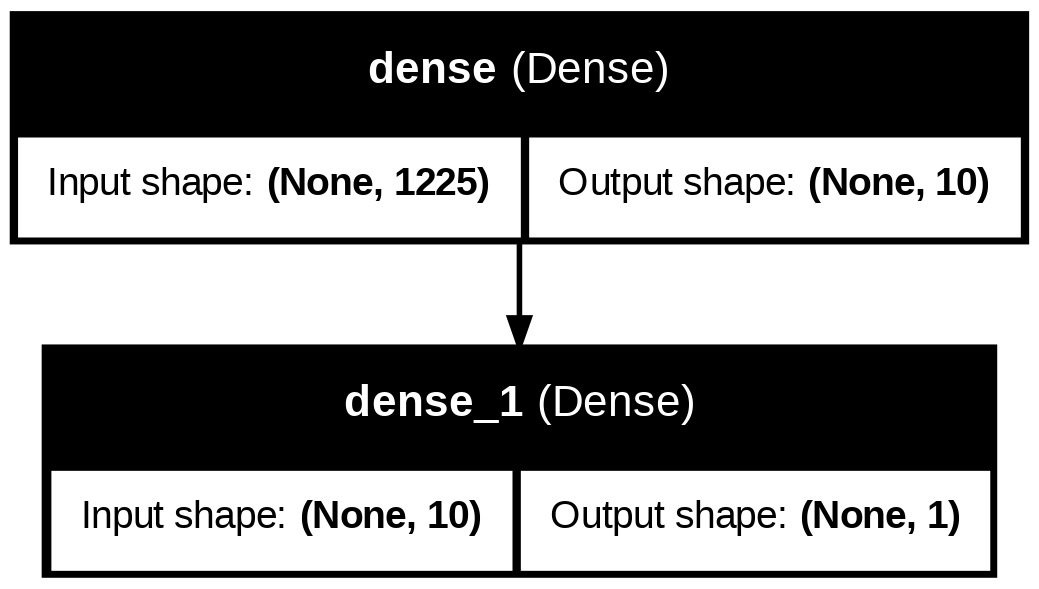

In [10]:
keras.utils.plot_model(rete1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [11]:
# Start my training -
batches, epoche, pazienza = 32, 20, 5
storia = rete1.fit(data, y,
                    batch_size=batches,
                    epochs=epoche,
                    validation_data=(data_val, y_val),
                    ) #callbacks=EarlyStopping(patience=pazienza,  restore_best_weights=True)

print("\n",storia.history.keys())

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5175 - loss: 0.7981 - val_accuracy: 0.5042 - val_loss: 0.7655
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4626 - loss: 0.7612 - val_accuracy: 0.5250 - val_loss: 0.7283
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5383 - loss: 0.7045 - val_accuracy: 0.5833 - val_loss: 0.7114
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6653 - loss: 0.6593 - val_accuracy: 0.6083 - val_loss: 0.7057
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5715 - loss: 0.6448 - val_accuracy: 0.4125 - val_loss: 0.7039
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6095 - loss: 0.6412 - val_accuracy: 0.4292 - val_loss: 0.7009
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6307 - loss: 0.6379 - val_accuracy: 0.4250 - val_loss: 0.7031
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6440 - loss: 0.6271 - val_accuracy: 0.4375 - val_loss: 0.7001


# Plots and test my network

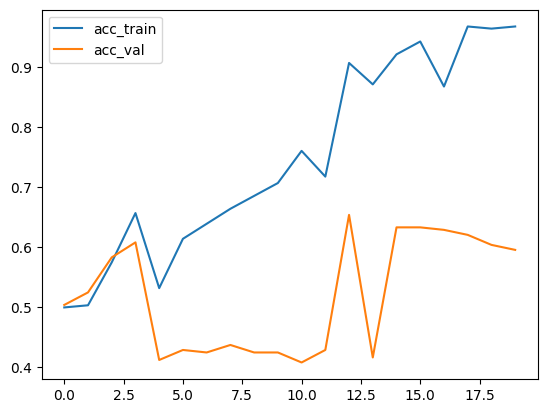

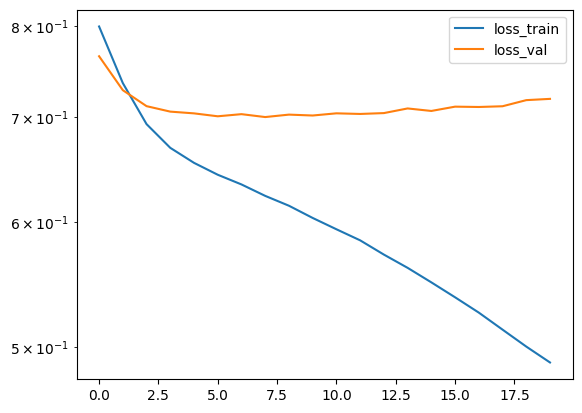

<Figure size 640x480 with 0 Axes>

In [12]:
"""################################################### Plots ####################################################"""

loss_train = storia.history["loss"]
loss_val = storia.history["val_loss"]
acc_train = storia.history["accuracy"]
acc_val = storia.history["val_accuracy"]

plt.plot(range(len(acc_train)), acc_train, label="acc_train")
plt.plot(range(len(acc_val)), acc_val, label="acc_val")
plt.legend()
plt.savefig("Accuracy_Ising2d")
plt.show()
plt.clf()

plt.yscale("log")
plt.plot(range(len(loss_train)), loss_train, label="loss_train")
plt.plot(range(len(loss_val)), loss_val, label="loss_val")
plt.legend()
plt.savefig("Loss_Ising2d")
plt.show()
plt.clf()

In [ ]:
"""################################################### Test ####################################################"""

yp_test = rete1.predict(data_test)                       # make my predictions
yp_ok_test = []
for i in yp_test:
    yp_ok_test.append(i[0])
yp_ok_test = np.array(yp_ok_test)

total_predictions = len(y_test)
correct_predictions = 0
erroneous_predictions = 0                               # calculating the total, erroneous and correct predictions
for i in range(total_predictions):
    if abs(y_test[i] - yp_ok_test[i]) < 0.5:
        correct_predictions = correct_predictions + 1
    else:
        erroneous_predictions = erroneous_predictions + 1

print("test predictions:\ntotal/correct/erroneous:\n", total_predictions, "/", correct_predictions, "/", erroneous_predictions, "/")
print("test Accuracy= ", correct_predictions / total_predictions)

# Tests

In [ ]:
import numpy as np
from urllib.request import urlopen

git_path = 'https://raw.githubusercontent.com/Nemenick/AIPHY24_GNN_Giagu/main/35conf10.dat'

response = urlopen(git_path)
data = np.loadtxt(response)

print(data)

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1.  1. -1.]
 [-1. -1.  1. ... -1. -1.  1.]
 [ 1.  1. -1. ... -1. -1.  1.]]


In [ ]:
git_path = 'https://raw.githubusercontent.com/Nemenick/FCA_DeepNeuralNework-with-TensorFlow/main/'
# if read_file I load my data than generating them! (files have to exist before I lunch this section)
# file = open(git_path + str(n) + "conf" + str(ntrain) + ".dat", "r")
# file_y = open(git_path + str(n) + "conf" + str(ntrain) + "y.dat", "r")
data = np.loadtxt(urlopen(git_path + str(n) + "conf" + str(ntrain) + ".dat"))
y = np.loadtxt(urlopen(git_path + str(n) + "conf" + str(ntrain) + "y.dat"))

# file = open(git_path + str(n) + "conf" + str(nval) + ".dat", "r")
# file_y = open(str(n) + "conf" + str(nval) + "y.dat", "r")
data_val = np.loadtxt(urlopen(git_path + str(n) + "conf" + str(nval) + ".dat"))
y_val = np.loadtxt(urlopen(git_path + str(n) + "conf" + str(nval) + "y.dat"))

# file = open(git_path + str(n) + "conf" + str(ntest) + ".dat", "r")
# file_y = open(git_path + str(n) + "conf" + str(ntest) + "y.dat", "r")
data_test = np.loadtxt(urlopen(git_path + str(n) + "conf" + str(ntest) + ".dat"))
y_test = np.loadtxt(urlopen(git_path + str(n) + "conf" + str(ntest) + "y.dat"))

In [ ]:
git_path

'https://raw.githubusercontent.com/Nemenick/AIPHY24_GNN_Giagu/main/35conf10.dat'

In [ ]:
response